In [3]:
import os
import struct
import numpy as np

In [4]:
def load_mnist(path, kind = 'train'):
    labels_path = os.path.join(path, '%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path, '%s-images-idx3-ubyte' % kind)
    
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = np.fromfile(lbpath, dtype = np.uint8)
    
    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack('>IIII', imgpath.read(16))
        images = np.fromfile(imgpath,
                             dtype = np.uint8).reshape(
            len(labels), 784)
        images = ((images / 255.) - .5) * 2
    
    return images, labels

In [5]:
X_train, y_train = load_mnist('', kind = 'train')
print('rows: %d, cols: %d' %(X_train.shape[0], X_train.shape[1]))

rows: 60000, cols: 784


In [6]:
X_test, y_test = load_mnist('', kind='t10k')
print('Rows: %d, columns: %d' % (X_test.shape[0], X_test.shape[1]))

Rows: 10000, columns: 784


## Visualize images

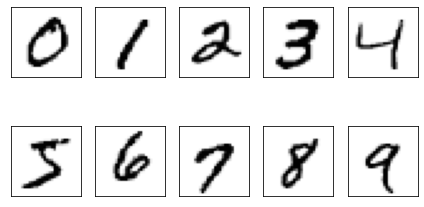

In [10]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=2, ncols=5,
                       sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X_train[y_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

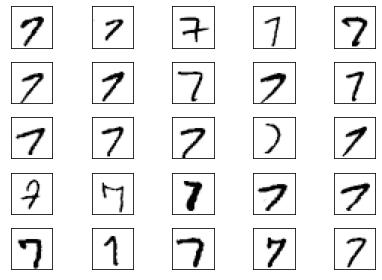

In [11]:
fig, ax = plt.subplots(nrows=5,ncols=5,
                       sharex=True,
                       sharey=True)
ax = ax.flatten()
for i in range(25):
    img = X_train[y_train == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [12]:
# save data as npz file
import numpy as np
np.savez_compressed('mnist_scaled.npz',
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test)

In [13]:
# reload MNIST image arrays
mnist = np.load('mnist_scaled.npz')
mnist.files

['X_train', 'y_train', 'X_test', 'y_test']

In [14]:
X_train, y_train, X_test, y_test = [mnist[f] for
                                    f in mnist.files]

### MLP

In [18]:
import numpy as np
import sys

class NeuralNetMLP(object):
    def __init__(self, n_hidden=30,
             l2=0., epochs=100, eta=0.001,
             shuffle=True, minibatch_size=1, seed=None):
        self.random = np.random.RandomState(seed)
        self.n_hidden = n_hidden
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.shuffle = shuffle
        self.minibatch_size = minibatch_size
        
    def _onehot(self, y, n_classes):
        onehot = np.zeros((n_classes, y.shape[0]))
        for idx, val in enumerate(y.astype(int)):
            onehot[val, idx] = 1.
        return onehot.T
    
    def _sigmoid(self, z):
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))
    
    def _forward(self, X):
        # step 1: net input of hidden layer
        # [n_examples, n_features] dot [n_features, n_hidden]
        # -> [n_examples, n_hidden]
        z_h = np.dot(X, self.w_h) + self.b_h
        # step 2: activation of hidden layer
        a_h = self._sigmoid(z_h)
        # step 3: net input of output layer
        # [n_examples, n_hidden] dot [n_hidden, n_classlabels]
        # -> [n_examples, n_classlabels]
        z_out = np.dot(a_h, self.w_out) + self.b_out
        # step 4: activation output layer
        a_out = self._sigmoid(z_out)
        return z_h, a_h, z_out, a_out
    
    def _compute_cost(self, y_enc, output):
        L2_term = (self.l2 *
               (np.sum(self.w_h ** 2.) +
                np.sum(self.w_out ** 2.)))
        term1 = -y_enc * (np.log(output))
        term2 = (1. - y_enc) * np.log(1. - output)
        cost = np.sum(term1 - term2) + L2_term
        return cost
    
    def predict(self, X):
        z_h, a_h, z_out, a_out = self._forward(X)
        y_pred = np.argmax(z_out, axis=1)
        return y_pred

    def fit(self, X_train, y_train, X_valid, y_valid):
        n_output = np.unique(y_train).shape[0]
        n_features = X_train.shape[1]

        self.b_h = np.zeros(self.n_hidden)
        self.w_h = self.random.normal(loc=0.0, scale=0.1,
                              size=(n_features,
                                    self.n_hidden))
        
        self.b_out = np.zeros(n_output)
        self.w_out = self.random.normal(loc=0.0, scale=0.1,
                                size=(self.n_hidden,
                                      n_output))
        epoch_strlen = len(str(self.epochs)) # for progr. format.
        self.eval_ = {'cost': [], 'train_acc': [], 'valid_acc': \
                      []}
        y_train_enc = self._onehot(y_train, n_output)
        
        for i in range(self.epochs):
            # iterate over minibatches
            indices = np.arange(X_train.shape[0])
            if self.shuffle:
                self.random.shuffle(indices)
            for start_idx in range(0, indices.shape[0] -\
                                   self.minibatch_size +\
                                   1, self.minibatch_size):
                batch_idx = indices[start_idx:start_idx +\
                                    self.minibatch_size]
                # forward propagation
                z_h, a_h, z_out, a_out = \
                    self._forward(X_train[batch_idx])
                
                # back propagation
                # [n_examples, n_classlabels]
                delta_out = a_out - y_train_enc[batch_idx]
                # [n_examples, n_hidden]
                sigmoid_derivative_h = a_h * (1. - a_h)
                # [n_examples, n_classlabels] dot [n_classlabels,
                #                                 n_hidden]
                # -> [n_examples, n_hidden]
                delta_h = (np.dot(delta_out, self.w_out.T) *
                           sigmoid_derivative_h)
                # [n_features, n_examples] dot [n_examples,
                #                               n_hidden]
                # -> [n_features, n_hidden]
                grad_w_h = np.dot(X_train[batch_idx].T, delta_h)
                grad_b_h = np.sum(delta_h, axis=0)
                # [n_hidden, n_examples] dot [n_examples,
                #                            n_classlabels]
                # -> [n_hidden, n_classlabels]
                grad_w_out = np.dot(a_h.T, delta_out)
                grad_b_out = np.sum(delta_out, axis=0)
                # Regularization and weight updates
                delta_w_h = (grad_w_h + self.l2*self.w_h)
                delta_b_h = grad_b_h # bias is not regularized
                self.w_h -= self.eta * delta_w_h
                self.b_h -= self.eta * delta_b_h
                delta_w_out = (grad_w_out + self.l2*self.w_out)
                delta_b_out = grad_b_out # bias is not regularized
                self.w_out -= self.eta * delta_w_out
                self.b_out -= self.eta * delta_b_out
                
            # Evaluation after each epoch during training
            z_h, a_h, z_out, a_out = self._forward(X_train)
            cost = self._compute_cost(y_enc=y_train_enc,
                                      output=a_out)
            y_train_pred = self.predict(X_train)
            y_valid_pred = self.predict(X_valid)
            
            train_acc = ((np.sum(y_train == y_train_pred)).astype(np.float) /
                            X_train.shape[0])
            valid_acc = ((np.sum(y_valid == y_valid_pred)).astype(np.float) /
                            X_valid.shape[0])
            sys.stderr.write('\r%0*d/%d | Cost: %.2f '
                                '| Train/Valid Acc.: %.2f%%/%.2f%% '
                                 %
                                (epoch_strlen, i+1, self.epochs, cost,
                                 train_acc*100, valid_acc*100))
            sys.stderr.flush()
            self.eval_['cost'].append(cost)
            self.eval_['train_acc'].append(train_acc)
            self.eval_['valid_acc'].append(valid_acc)
        return self


In [19]:
nn = NeuralNetMLP(n_hidden=100,l2=0.01,
                  epochs=200,
                  eta=0.0005,
                  minibatch_size=100,
                  shuffle=True,
                  seed=1)

In [20]:
nn.fit(X_train=X_train[:55000],
       y_train=y_train[:55000],
       X_valid=X_train[55000:],
       y_valid=y_train[55000:])

200/200 | Cost: 5065.78 | Train/Valid Acc.: 99.28%/97.98%  

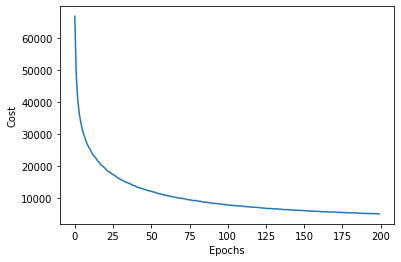

In [21]:
import matplotlib.pyplot as plt

# plot epochs vs cost
plt.plot(range(nn.epochs), nn.eval_['cost'])
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.show()

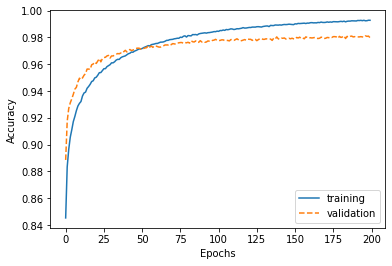

In [24]:
# plot training and validation accuracy vs epochs
plt.plot(range(nn.epochs), nn.eval_['train_acc'],
         label='training')
plt.plot(range(nn.epochs), nn.eval_['valid_acc'],
    label='validation', linestyle='--')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.show()

In [25]:
y_test_pred = nn.predict(X_test)
acc = (np.sum(y_test == y_test_pred)
       .astype(np.float) / X_test.shape[0])
print('Test accuracy: %.2f%%' % (acc * 100))

Test accuracy: 97.54%


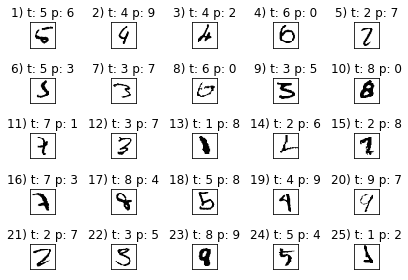

In [27]:
# look at images that are mismatched
miscl_img = X_test[y_test != y_test_pred][:25]
correct_lab = y_test[y_test != y_test_pred][:25]
miscl_lab = y_test_pred[y_test != y_test_pred][:25]

fig, ax = plt.subplots(nrows=5, ncols=5,
                       sharex=True,sharey=True,)
ax = ax.flatten()
for i in range(25):
    img = miscl_img[i].reshape(28, 28)
    ax[i].imshow(img,
             cmap='Greys',
             interpolation='nearest')
    ax[i].set_title('%d) t: %d p: %d' % (i+1, correct_lab[i], miscl_lab[i]))
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()
